## (Task 1) Gathering Retail Data

For this task, I have used the data about the average price of Avocados calculated using nationwide sales data. This data is available on the [website](https://www.hassavocadoboard.com/retail/volume-and-price-data) of the Hass Avocado Board.

It contains region-wise, as well as nation-wide data regarding the sale and the prices of avocados. I have considered the cumulative nationwide data for transactional analysis, and the regional data for statistical and exploratory analysis.

### Importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")
import glob
import os
import warnings
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import autopep8
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import sqlite3

### Importing Data and Combining CSV Files
The dataset is located in the `data` folder, with the CSV files pertaining to yearwise data for conventional avocados in `data\conventional` folder, and those pertaining to organic in `data\organic`.

In the following cells, we'll concatenate the yearwise data for conventional avocados for the years 2016, 2017, and 2018 into one dataframe.

In [2]:
path = 'data/Conventional'
all_files = glob.glob(os.path.join(path, "*.csv"))

df_from_each_file = (pd.read_csv(f) for f in all_files)
conventional_df = pd.concat(df_from_each_file, ignore_index=True)

#### Converting Dates to pandas datetime format

In [3]:
conventional_df['Date'] = pd.to_datetime(conventional_df['Date'])
conventional_df.set_index('Date', inplace=True)

#### Sorting by date in chronological order

In [4]:
conventional_df = conventional_df.sort_index()

### Doing the same for the Organic dataset

In [5]:
path = 'data/Organic'
all_files = glob.glob(os.path.join(path, "*.csv"))

df_from_each_file = (pd.read_csv(f) for f in all_files)
organic_df = pd.concat(df_from_each_file, ignore_index=True)

In [6]:
organic_df['Date'] = pd.to_datetime(organic_df['Date'])
organic_df.set_index('Date', inplace=True)

In [7]:
organic_df = organic_df.sort_index()
print(organic_df)

            AveragePrice  Total Volume       4046       4225      4770  \
Date                                                                     
2016-01-03          1.43     704100.50  124799.63  246580.95   7749.40   
2016-01-10          1.35     828670.59  113867.63  287590.19   8771.79   
2016-01-17          1.44     695341.42  115992.81  266824.72  13106.29   
2016-01-24          1.41     776964.55   99316.69  270980.88  12933.97   
2016-01-31          1.43     772077.20  108929.21  269687.52   5515.91   
2016-02-07          1.44     758795.10  101408.79  290813.54   8028.75   
2016-02-14          1.37     852463.31  102897.63  306235.69   6955.69   
2016-02-21          1.45     738856.92  104135.94  281188.89   8629.03   
2016-02-28          1.44     845011.63  110120.49  347488.78  10423.30   
2016-03-06          1.28    1012415.85  127184.88  351951.65   5698.20   
2016-03-13          1.29    1023655.87  132040.04  346341.46   6709.65   
2016-03-20          1.27    1045450.41

## (Task 3) Sanitizing for missing dates
### We'll check the conventional avocado dataset for any missing values

In [8]:
conventional_df.isnull().sum()

AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
dtype: int64

Since we didn't find any missing values, we don't need to sanitize it.

### Checking the organic avocado dataset

In [9]:
organic_df.isnull().sum()

AveragePrice    1
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
dtype: int64

We find that there's one missing value. We'll now need to sanitize for it.

### Sanitization
Given the nature of the dataset and the fact that only one value is missing, it's appropriate to use **mean imputation** to fill in the missing value. We'll use the pandas `fillna` function to do so. 

In [10]:
organic_df.fillna(organic_df.mean(),inplace=True)

In [11]:
organic_df.isnull().sum()

AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
dtype: int64

As we can see, there are no more missing values.

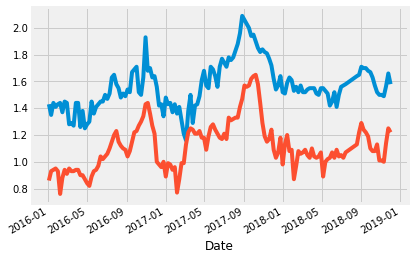

In [12]:
organic_df['AveragePrice'].plot()
conventional_df['AveragePrice'].plot()

## Implementing ARIMA, forecasting, storing in database

For convenience, I'll only consider the Organic avocado dataset from here on out. It's trivial to implement the same for the conventional avocado dataset as well.

### Dropping unnececessary columns

In [13]:
organic_df = organic_df.drop(columns = ['Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'XLarge Bags'])

### Initializing database
I'll create the connection `con` to the database `Parameters.db`.

In [14]:
con = sqlite3.connect('Parameters.db')

I'll create the cursor `cur` to operate on the database.

In [15]:
cur = con.cursor()

I first check if the table `arimaparams` already exists, if it doesn't I create it. 

In [16]:
tablesql = "CREATE TABLE IF NOT EXISTS arimaparams (p text, d text, q text, mse text)"
cur.execute(tablesql)

I define `insert_sql` to be the SQL query to insert values into the `arimaparams` table.

In [17]:
insert_sql = "INSERT INTO arimaparams (p, d, q, mse) VALUES (?,?,?,?)"

In [18]:
#To evaluate ARIMA model, X = dataframe, arima_order = (p,d,q)
def arima_error_calculation(X, arima_order):
	# split data-sets into training and test
	train_size = int(len(X) * 0.65)
	train = X[0:train_size]
	test = X[train_size:]
	history = [x for x in train]
	# use ARIMA to predict
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate errors
	error = mean_squared_error(test, predictions)
	return error

# grid search for p, d, q values to evaluate ARIMA
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = arima_error_calculation(dataset, order)
					cur.execute(insert_sql,(p,d,q,mse))
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA with p, d, q%s gives MSE=%.5f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.5f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(organic_df.values, p_values, d_values, q_values)

ARIMA with p, d, q(0, 0, 0) gives MSE=0.00814
ARIMA with p, d, q(0, 0, 1) gives MSE=0.00364
ARIMA with p, d, q(0, 0, 2) gives MSE=0.00316
ARIMA with p, d, q(0, 0, 3) gives MSE=0.00274
ARIMA with p, d, q(0, 1, 0) gives MSE=0.00277
ARIMA with p, d, q(0, 1, 1) gives MSE=0.00297
ARIMA with p, d, q(0, 1, 2) gives MSE=0.00301
ARIMA with p, d, q(0, 1, 3) gives MSE=0.00310
ARIMA with p, d, q(0, 2, 0) gives MSE=0.00537
ARIMA with p, d, q(0, 2, 1) gives MSE=0.00286
ARIMA with p, d, q(1, 0, 0) gives MSE=0.00241
ARIMA with p, d, q(1, 0, 1) gives MSE=0.00256
ARIMA with p, d, q(1, 0, 2) gives MSE=0.00259
ARIMA with p, d, q(1, 1, 0) gives MSE=0.00287
ARIMA with p, d, q(1, 1, 1) gives MSE=0.00305
ARIMA with p, d, q(1, 2, 0) gives MSE=0.00451
ARIMA with p, d, q(1, 2, 1) gives MSE=0.00296
ARIMA with p, d, q(2, 0, 0) gives MSE=0.00251
ARIMA with p, d, q(2, 0, 1) gives MSE=0.00250
ARIMA with p, d, q(2, 0, 2) gives MSE=0.00260
ARIMA with p, d, q(2, 0, 3) gives MSE=0.00267
ARIMA with p, d, q(2, 1, 0) gives 

In [19]:
cur.execute("SELECT * FROM arimaparams")

In [20]:
cur.fetchall()

[('0', '0', '0', '0.00813997638295601'),
 ('0', '0', '1', '0.00363893091418205'),
 ('0', '0', '2', '0.00315633571688102'),
 ('0', '0', '3', '0.00274191056418425'),
 ('0', '1', '0', '0.00277373627603646'),
 ('0', '1', '1', '0.00296562274556327'),
 ('0', '1', '2', '0.00300683679979873'),
 ('0', '1', '3', '0.00310310159377464'),
 ('0', '2', '0', '0.00537464231003507'),
 ('0', '2', '1', '0.00285598696718592'),
 ('1', '0', '0', '0.00241281075119629'),
 ('1', '0', '1', '0.00256267669830949'),
 ('1', '0', '2', '0.00259331296490301'),
 ('1', '1', '0', '0.00287206617015032'),
 ('1', '1', '1', '0.00305405501887583'),
 ('1', '2', '0', '0.0045130918233474'),
 ('1', '2', '1', '0.00295734487681217'),
 ('2', '0', '0', '0.00250740746585089'),
 ('2', '0', '1', '0.00250141888130366'),
 ('2', '0', '2', '0.00260344458452661'),
 ('2', '0', '3', '0.00266716024277305'),
 ('2', '1', '0', '0.0028608728273945'),
 ('2', '1', '1', '0.00302027271586157'),
 ('2', '2', '0', '0.00367721412134054'),
 ('2', '2', '1', '

In [21]:
con.close()

In [22]:
model = ARIMA(organic_df['AveragePrice'], order = (1, 0, 0))
results_ARIMA = model.fit()
predictions = round(results_ARIMA.predict(), 2)
preds = pd.DataFrame(list(zip(list(predictions.index),list(predictions))),columns=['Date',
                                                                                   'PredictedPrice']).set_index('Date')
predicted_df = pd.merge(organic_df[1:], preds, left_index=True, right_index=True)
predicted_df.head()

,AveragePrice,PredictedPrice
Date,,
2016-01-10,1.35,1.44
2016-01-17,1.44,1.37
2016-01-24,1.41,1.45
2016-01-31,1.43,1.43
2016-02-07,1.44,1.44


In [23]:

print("\tMean Squared Error:", mean_squared_error(predicted_df['AveragePrice'], predicted_df['PredictedPrice']))
print("\tRoot Mean Squared Error:", np.sqrt(mean_squared_error(predicted_df['AveragePrice'], 
                                                               predicted_df['PredictedPrice'])))

	Mean Squared Error: 0.006107601351351347
	Root Mean Squared Error: 0.07815114427410098


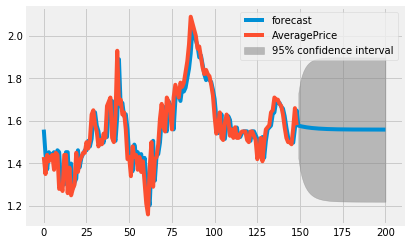

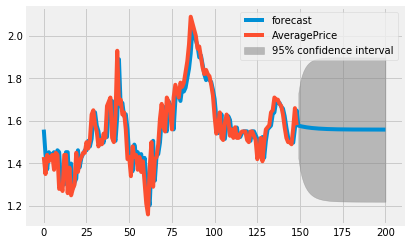

In [24]:
results_ARIMA.plot_predict(end=200)

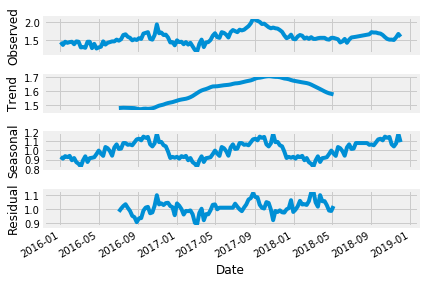

In [25]:
result = seasonal_decompose(organic_df, model='multiplicative',freq=52)
fig = result.plot()

In [26]:
sarimaxmod = sm.tsa.statespace.SARIMAX(organic_df['AveragePrice'],
                                order=(2, 1, 2), #Same as the optimal obtained
                                seasonal_order=(1, 0, 0, 52), #52 weeks in one year
                                enforce_stationarity=False,
                                enforce_invertibility=False)

SARIMAX_results = sarimaxmod.fit()

SARIMAX_predictions = SARIMAX_results.predict()

SARIMAX_preds = pd.DataFrame(list(zip(list(SARIMAX_predictions.index),list(SARIMAX_predictions))),
                             columns=['Date','PredictedPrice']).set_index('Date')

SARIMAX_predicted_df = pd.merge(organic_df[1:], SARIMAX_preds, left_index=True, right_index=True)
SARIMAX_predicted_df.tail()

,AveragePrice,PredictedPrice
Date,,
2018-11-04,1.500,1.511807
2018-11-11,1.490,1.502946
2018-11-18,1.565,1.489665
2018-11-25,1.660,1.562853
2018-12-02,1.580,1.640387


In [27]:
print("\tMSE:", mean_squared_error(SARIMAX_predicted_df['AveragePrice'], 
                                                  SARIMAX_predicted_df['PredictedPrice']))
print("\tRMSE:", np.sqrt(mean_squared_error(SARIMAX_predicted_df['AveragePrice'], 
                                                               SARIMAX_predicted_df['PredictedPrice'])))


	MSE: 0.007939576166187817
	RMSE: 0.08910429936982736


In [28]:
SARIMAX_forecast = pd.DataFrame(SARIMAX_results.forecast(steps = 40), columns = ['Forecasted Price'])

In [29]:
forecasted_dates = pd.date_range(start='2018-12-09', periods=40,freq='W')
SARIMAX_forecast.insert(0,'Date',forecasted_dates)
SARIMAX_forecast.set_index('Date',inplace=True)

In [30]:
print(SARIMAX_forecast)

            Forecasted Price
Date                        
2018-12-09          1.563363
2018-12-16          1.586464
2018-12-23          1.595287
2018-12-30          1.588946
2019-01-06          1.588440
2019-01-13          1.591655
2019-01-20          1.590717
2019-01-27          1.592737
2019-02-03          1.592503
2019-02-10          1.590737
2019-02-17          1.589690
2019-02-24          1.589982
2019-03-03          1.592447
2019-03-10          1.591638
2019-03-17          1.592963
2019-03-24          1.591293
2019-03-31          1.592878
2019-04-07          1.592907
2019-04-14          1.592274
2019-04-21          1.591940
2019-04-28          1.591937
2019-05-05          1.591943
2019-05-12          1.593227
2019-05-19          1.593545
2019-05-26          1.591941
2019-06-02          1.591942
2019-06-09          1.592584
2019-06-16          1.593224
2019-06-23          1.596110
2019-06-30          1.595149
2019-07-07          1.592904
2019-07-14          1.596431
2019-07-21    